In [3]:
!pip3 install causaldata
import causaldata
import numpy as np 
np.__version__
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel
from econml.dml import DML
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')

In [245]:
#Load dataset
d_pandas = causaldata.nsw_mixtape.load_pandas().data
# print(d_pandas.head(10))
d_pandas["re78"].mean()

5300.764

In [232]:
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def bootstrap(df, function, n=1000, ci=95, **kwargs):
    """
    Resample the dataframe `n` times. For each resampled dataframe,
        call `function(new_df, **kwargs)` and save its value.
    Return the confidence interval that covers the central `ci`% of these values

    If the passed `function(df)` returns an array of shape [6,],
        then `bootstrap(df, function)` should return an array of shape [2, 6]
        where the first row contains the bottom of the confidence interval
        and the second row contains the top of the confidence interval

    You may want to use `df.sample` and `np.percentile`
    """
    np.random.seed(42)  # Keep this random seed call for reproducibility
    
    values = []
    for i in range(n):
        # sample subset
        subset = df.sample(n= len(df), replace=True)
        values.append(function(subset))

    values = np.array(values) # (n, ?)
    result = []
    start, end = (100-ci)/2, ci + (100-ci)/2
    for i in range(len(values[0])):
        
        v = values[:, i]
        t = np.percentile(v, [2.5, 97.5])
        result.append(t)
    
    return np.transpose(np.array(result))


def backdoor(df, treat = "treat", confounders=["age", "black", "hisp"]):
    """
    A backdoor adjustment  estimator for E[Y^a]
    Use smf.ols to train an outcome model E(Y | A, confounders)

    Arguments
      df: a data frame for which to estimate the causal effect
      confounders: the variables to treat as confounders
          For the data we consider, if you include both c and d as confounders,
          this estimator should be unbiased. If you only include one,
          you would expect to see more bias.

    Returns
        results: an array of E[Y^a] estimates for each unique a value
    """
    results = []

    all_treatment = list(set(df[f"{treat}"].values))
    all_treatment.sort()

    formula = ""
    for c in confounders:
        formula += "+ "
        formula += c

    formula = f"re78 ~ C({treat}) " + formula

    model = smf.ols(formula, data=df).fit()

    temp = 0.0
    for a in all_treatment:

        if a == 0:
            temp = 0
            
        else:
            temp = model.params[f"C({treat})[T.{a}]"]

        i = 0
        intercept = model.params[0]

        lst = [np.mean(df[c])*model.params[c] for c in confounders]

        results.append(np.sum(lst) + temp + intercept)

    results = np.array(results)
    return results

In [52]:
##Use backdoor and calculate risk ratio
treatment = backdoor(d_pandas)
print('E[Y^a=0] without program:', treatment[1]/treatment[0]) # , 'E[Y^a=1] with program:', treatment[1])

#Use backdoor conditioning on whether they have a hghschool degree or not
nodegree_df = d_pandas[d_pandas["nodegree"] == 1]
degree_df = d_pandas[d_pandas["nodegree"] == 0]

print()

print('calculating E[Y] for subset nodegree=0/1:')
nodegree = backdoor(nodegree_df, treat="treat")
degree = backdoor(degree_df, treat="treat")
print('Risk Ratio for nodegree=0', degree[1]/degree[0], 'E[Y] for nodegree=1', nodegree[1]/nodegree[0])
print('Odds Ratio:', (degree[1]/degree[0])/(nodegree[1]/nodegree[0]))
print()

print('Some Stats')
print('Average Income:', d_pandas["re78"].mean(), 'std:',d_pandas["re78"].std() , 'Median income', d_pandas["re78"].median())
print('Average Income:', nodegree_df["re78"].mean(), 'std:',nodegree_df["re78"].std(), nodegree_df["re78"].median())
print('Average Income:', degree_df["re78"].mean(), 'std:',degree_df["re78"].std(), degree_df["re78"].median())

E[Y^a=0] without program: 1.3874041688401964

calculating E[Y] for subset nodegree=0/1:
Risk Ratio for nodegree=0 1.6455926065750153 E[Y] for nodegree=1 1.2673748256449975
Odds Ratio: 1.298426142982234

Some Stats
Average Income: 5300.764 std: 6631.4917 Median income 3701.812
Average Income: 4929.8413 std: 6311.5156 3557.14
Average Income: 6631.4966 std: 7557.5356 4812.576


In [246]:
#d_pandas = d_pandas[d_pandas["nodegree"] == 1]

bootstrap(d_pandas, backdoor)

array([[3766.81728811, 4480.42665075],
       [5221.072089  , 7032.9314961 ]])

In [42]:
print(d_pandas[ (d_pandas["nodegree"] == 1) & (d_pandas["treat"] == 1)]["re78"].mean())
print(d_pandas[ (d_pandas["nodegree"] == 1) & (d_pandas["treat"] == 0)]["re78"].mean())

print(d_pandas[ (d_pandas["nodegree"] == 0) & (d_pandas["treat"] == 1)]["re78"].mean())
print(d_pandas[(d_pandas["nodegree"] == 0) & (d_pandas["treat"] == 0)]["re78"].mean())

5649.462
4495.415
8046.518
4854.4927


In [16]:
from econml.dml import LinearDML
from econml.dml import NonParamDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import random
import shap
from econml.dml import SparseLinearDML
import econml
random.seed(40)

#####Load Data
d_pandas = causaldata.nsw_mixtape.load_pandas().data
#d_pandas=d_pandas[d_pandas['nodegree']==0]
##target variable
y=d_pandas.re78
##treatment
T=d_pandas.treat
##Observed confounders
W= d_pandas[['nodegree']]
##Other observed variables
X=d_pandas[['black','hisp','marr','educ','age']]

####Estimator using unregularized final inear model
est1 = LinearDML(discrete_treatment=True,random_state=42) # This line sets the parametters of the DML estimator, the most importat ones are
                                                         # the type of model used for each step of the estimation. Here left to logistic regression and LassoCV
est1.fit(y, T, X=X,W=W,inference=econml.inference.BootstrapInference(n_bootstrap_samples=1000, n_jobs=-1))  #Specify features, target, treatment and observed confounders
                                                                                                            # also bootstrap settings

print('ATE LinearDML')
print(est1.ate(X)) #print average treatment effect
print(est1.ate_interval(X))#print bootstrap intervals

#lb, ub = est1.effect_interval(X,alpha=0.05)
#print(lb , ub)

###Non parametric estimator (makes no assumption onthe effect model

est2 = NonParamDML(
    model_y=RandomForestRegressor(min_samples_leaf=20),
    model_t=RandomForestClassifier(min_samples_leaf=20),
    model_final=RandomForestRegressor(min_samples_leaf=20),
    discrete_treatment=True,random_state=42
)# This line sets the parametters of the DML estimator, the most importat ones are
    # the type of model used for each step of the estimation. Here left to random forest and random classifier
est2.fit(y, T, X=X,W=W,inference=econml.inference.BootstrapInference(n_bootstrap_samples=1000, n_jobs=-1)) #same as before specifying parameters
print('ATE NonParamDML')

print(est2.ate(X))
print(est2.ate_interval(X))




ATE LinearDML
1560.381136049834
(-1776.7572330248527, 4897.519505124519)
ATE NonParamDML
1747.2529997880931
(-2717.1703242792028, 6211.676323855388)


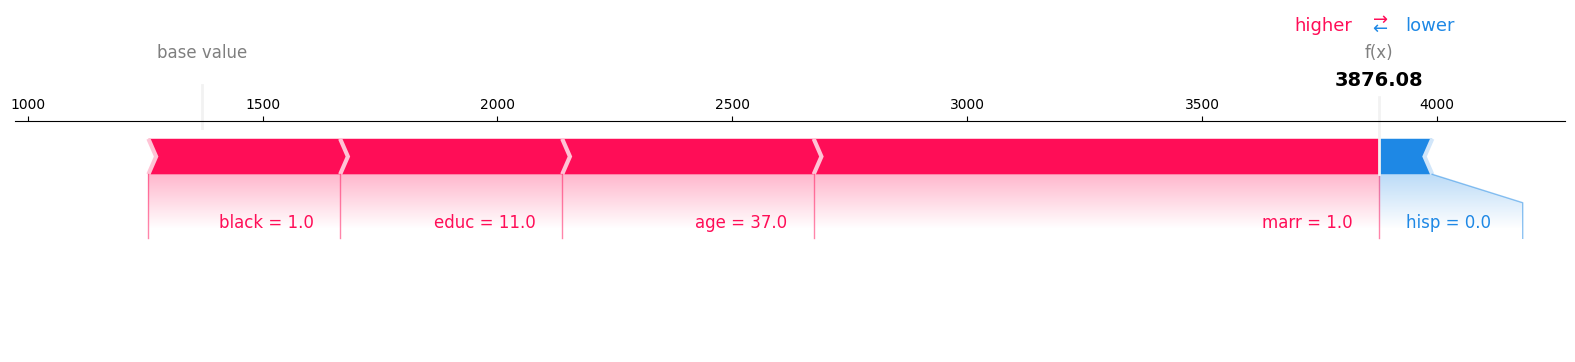

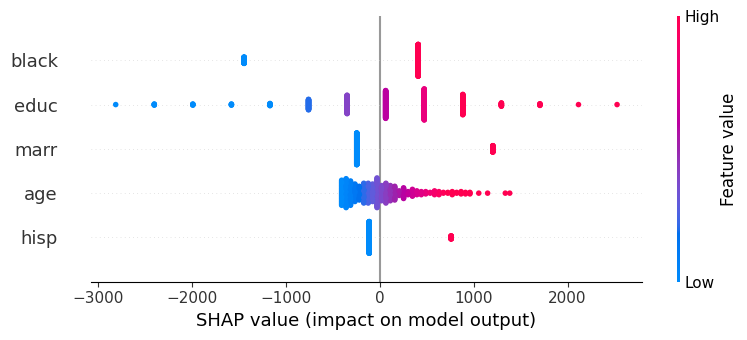

In [15]:
######### Plot shapley values to understand models
shap_values = est1.shap_values(X)
# local view: explain hetergoeneity for a given observation
ind=0
shap.plots.force(shap_values["re78"]["treat_1"][ind], matplotlib=True)
# global view: explain hetergoeneity for a sample of dataset
shap.summary_plot(shap_values['re78']['treat_1'])

In [14]:
print(est1.coef_)
est1.model_y

[1854.92987011  872.35573478 1449.48321998  410.89431027   47.11807027]


'auto'